In [2]:
import cv2
from __future__ import division, print_function
import numpy as np
# given an image and a list of points, we want to extract patches s.t. they are centered (vertically) on the tail edge
# we also want to extract negative patches, but this is a different task
def extract(img, center, size):
    # assume center is in x, y format
    upper_border = center[1] - size[0]//2
    lower_border = center[1] + size[0]//2
    left_border = center[0] - size[1]//2
    right_border = center[0] + size[1]//2
    
    extracted_patch = img[max(0,upper_border):min(img.shape[0],lower_border),
                          max(0,left_border):min(img.shape[1],right_border)]
    
    fillrow_amount = 0
    if upper_border < 0:
        fillrow_amount = upper_border
    elif lower_border > img.shape[0]: # assume that the patch's y isn't > img's y
        fillrow_amount = lower_border - img.shape[0]
    
    # fill the row before we fill the col if we need to
    if fillrow_amount != 0:
        tovstack = [extracted_patch]
        if fillrow_amount < 0:
            tovstack.insert(0,[extracted_patch[0,:]]*abs(fillrow_amount))
        else:
            tovstack.append([extracted_patch[-1,:]]*fillrow_amount)
        extracted_patch = np.vstack(tovstack)
            
    fillcol_amount = None
    if left_border < 0:
        fillcol_amount = left_border
    elif right_border > img.shape[1]:
        fillcol_amount = right_border - img.shape[1]
    
    if fillcol_amount != 0:
        tohstack = [extracted_patch]
        if fillcol_amount < 0:
            tohstack.insert(0,[extracted_patch[:,0].reshape(-1,1)]*abs(fillcol_amount))
        else:
            tohstack.append([extracted_patch[:,-1].reshape(-1,1)]*fillcol_amount)
        extracted_patch = np.hstack(tohstack)
    
    assert(extracted_patch.shape == size)
    return extracted_patch, upper_border
    
def find_best_y(img, lower_real_coord):    
    centerx = img.shape[1] // 2
    gradient_y_image = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)
    new_y_center = np.argmax(gradient_y_image[:,centerx])
    return new_y_center

def extract_candidates(img, point_list, size):
    candidates = []
    for point in point_list:
        initial_candidate, upper_border = extract(img, size, point)
        new_y_center = upper_border + find_best_y(initial_candidate) # point is x,y
        candidates.append(extract(img, size, (point[0],new_y_center)))
    return candidates

def line_between(p1, p2):
    # return a function that gives the line between p1 and p2
    # so that we can extract patches along that line
    d = (p2[0] - p1[0], p2[1] - p1[1])
    return lambda t: (p1[0] + t*d[0], p1[1] + t*d[1]) 

def sample_along_line(p1, p2, size):
    # we want to determine how many steps along the line we'll sample so that we have no overlapping boxes
    # we can assume that p1[x] < p2[x], i.e. we're going left to right
    # if the angle that the line between p1 and p2 makes is between 45 and -45
    line = line_between(p1, p2)
    dX = p2[0] - p1[0]
    dY = p2[1] - p1[1]
    distance = np.sqrt(dX**2 + dY**2)
    angle_between = np.arctan2(-1*dY,dX) # multiply by -1 since Y increases as it goes down
    if abs(angle_between) > (np.pi / 4):
        movement_amount = np.sin(angle_between)*size[1] # assume size[1] is y
    else:
        movement_amount = np.cos(angle_between)*size[0] # assume size[0] is x
    line_percentage = 0.75*min(1.,abs(movement_amount) / distance)
    t = 0 #line_percentage # the first one will be right outside of the bounding box
    centers = []
    while(t < (1-line_percentage)):
        centers.append(line(t + line_percentage))
        t += line_percentage
    return centers

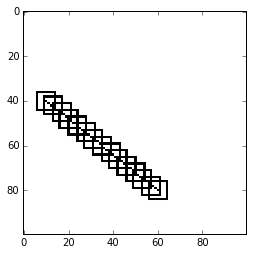

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

def display_boxes(canvas_size, p1, p2, size):
    canvas = np.ones(canvas_size)
    all_points = [p1] + sample_along_line(p1, p2, size) + [p2]
    for point in all_points:
        upper_left = tuple(map(int,(point[0] - size[0]//2, point[1] - size[1]//2)))
        bottom_right = tuple(map(int,(point[0] + size[0]//2, point[1] + size[1]//2)))
        #print(upper_left)
        #print(bottom_right)
        cv2.rectangle(canvas, upper_left, bottom_right, color=0)
    cv2.line(canvas, p1, p2, color=0)
    plt.gray()
    plt.imshow(canvas,interpolation='none')
    

#sample_along_line((10,200),(30,400),(16,16))
display_boxes((100,100),(10,40),(60,80),(8,8))   

In [44]:
def find_seam(img, start, end, center=None, n_neighbors=3):
    assert(n_neighbors % 2 == 1)
    neighbor_range = range(-1*(n_neighbors // 2),1+(n_neighbors // 2))
    # start and end are x,y
    # take the vertical gradients of the image
    gradient_y_image = -1*cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)
    # TODO maybe: blur before taking gradients to denoise
    # set the start point's vertical gradient to a very high value
    # for each row from start to end, the cost of each cell is the max
    # of the three neighbors to its left + its own cost
    # the max that is chosen is then stored for each pixel in a column so we can backtrack
    gradient_y_image[:,start[0]] = -np.inf # make sure this is where the path starts
    gradient_y_image[start[1],start[0]] = 0 #np.max(gradient_y_image) + 1 # yeah I think this makes sense
    
    gradient_y_image[:,end[0]] = -np.inf
    gradient_y_image[end[1],end[0]] = 0 #np.max(gradient_y_image) + 1
    if center is not None:
        # force it to go through the center
        gradient_y_image[:,end[0]] = -np.inf
        gradient_y_image[end[1],end[0]] = 0
    # the goal of the above is to make the path end at 'end', but that probably can't be guaranteed regardless
    cost = np.zeros(gradient_y_image.shape)
    back = np.zeros(gradient_y_image.shape,dtype=np.int32)
    get_cost = lambda row, col, i : -np.inf if ((row+i < 0) or (row+i >= gradient_y_image.shape[0])) else cost[row+i,col-1] + gradient_y_image[row,col]
    for col in range(start[0],end[0]+1):
        # this is the slow part
        for row in range(gradient_y_image.shape[0]):
            #candidates = [((cost[cell+i, col-1]+gradient_y_image[cell,col]) if
            #              ((cell+i > 0) and (cell+i < gradient_y_image.shape[0])) else -np.inf) 
            #              for i in (-1,0,1)]
            #print(get_cost(row, col, 1))
            candidates = [get_cost(row, col, i) for i in neighbor_range]
            best = np.argmax(candidates)
            #print(candidates)
            back[row, col] = best - (n_neighbors // 2)
            cost[row, col] = candidates[best]
    # backtrack the seam
    path = [] # we know that the path is from end to start so we don't need to store the x values
    curr_y = end[1]
    path_cost = 0
    # we know that the optimal path must end at the end point since otherwise its cost is -inf
    for col in range(start[0],end[0]+1)[::-1]:
        path_cost += cost[curr_y,col]
        path.append(curr_y) 
        next_ = curr_y + back[curr_y,col]
        curr_y = next_
    #plt.imshow(cost)
    return path, path_cost, cost

In [46]:
with open('../dataset_loc','r') as f:
    dataset_loc = f.read().rstrip()
from os.path import join
import random
import glob
imgs_dir = join(dataset_loc,'Flukes/CRC_combined constrained/')
all_imgfn = glob.glob(join(imgs_dir,'*'))
test_img = cv2.cvtColor(cv2.imread(random.choice(all_imgfn)),cv2.COLOR_BGR2GRAY)
print(test_img.shape)
start = (0,0)
end = (950,0)
path, path_cost, test_cost = find_seam(test_img, start,end, n_neighbors=7)
print(path_cost)
print(path[0])
print(path[-1])

        

(244, 960)
2108869072.0
0
0


In [48]:
def color_path(img, path, start, end):
    color_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    col = end[0]
    for row in path:
        color_img[row, col,:] = np.array([255,0,0])
        col -= 1
    return color_img
    
colored_img = color_path(test_img, path, start, end)

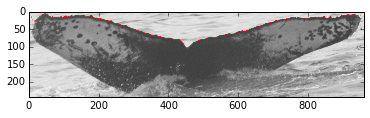

In [49]:
plt.imshow(colored_img)

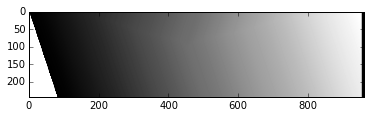

In [50]:
plt.imshow(test_cost)

In [40]:
import cPickle as pickle
def load_coords():
    with open(join(dataset_loc, 'Flukes/extracted_zsl_annotations.pkl'), 'r') as f:
        return pickle.load(f)
coords_id_img_map = load_coords()

12338


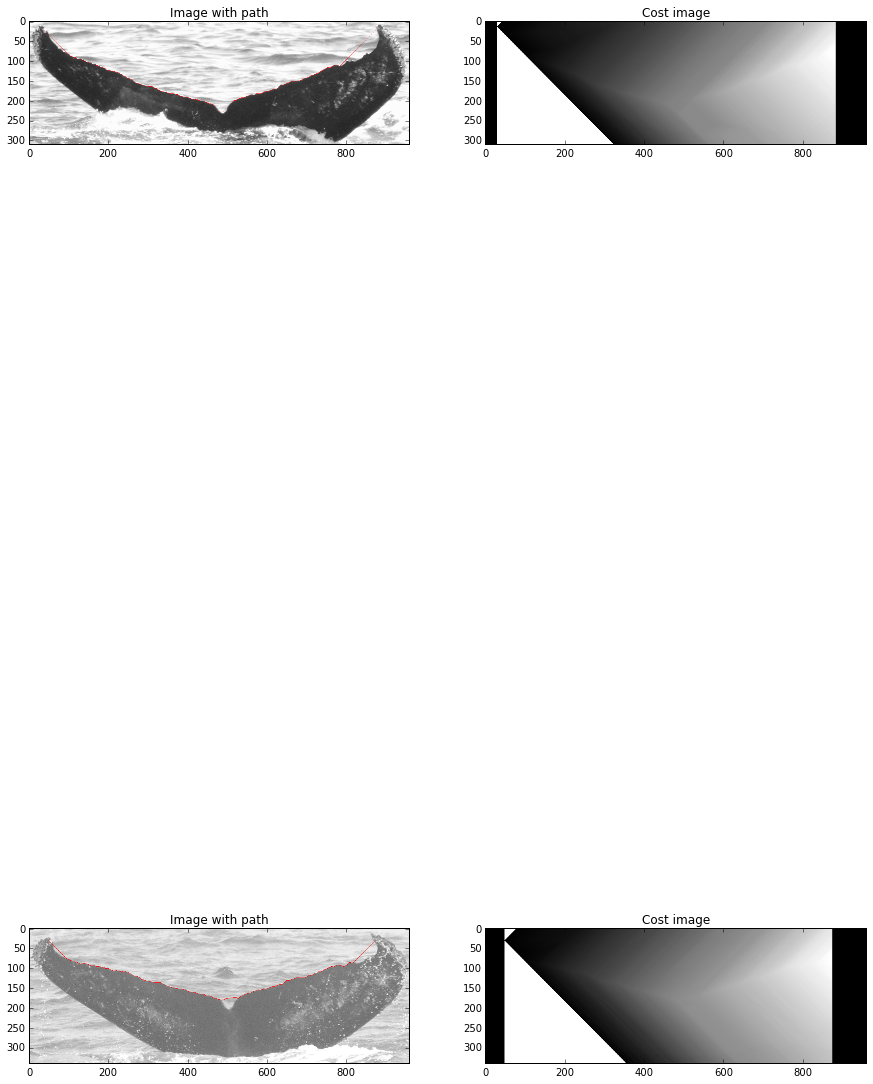

In [61]:
def edge_img(patch_coord, n_neighbors=7):
    img = cv2.cvtColor(cv2.imread(join(imgs_dir, patch_coord['fn'])),cv2.COLOR_BGR2GRAY)
    left = patch_coord['left']
    right = patch_coord['right']
    center = patch_coord['notch']
    
    path, path_cost, cost_img = find_seam(img, left, right, center=center, n_neighbors=n_neighbors)
    colored_img = color_path(img, path, left, right)
    return colored_img, cost_img

def show_edge(indv, coord_map, max_images=10):
    fig, axarr = plt.subplots(min(len(coord_map[indv]),max_images),2, figsize=(15,30))
    for ind, patch_coord in list(enumerate(coord_map[indv]))[:max_images]:
        show_img, cost_img = edge_img(patch_coord, n_neighbors=3)
        axarr[ind,0].set_title("Image with path")
        axarr[ind,1].set_title("Cost image")
        axarr[ind,0].imshow(show_img)
        axarr[ind,1].imshow(cost_img)

rand_indv = random.choice(coords_id_img_map.keys())
print(rand_indv)
show_edge(rand_indv, coords_id_img_map)